## Proste metody iteracyjne rozwiązuywania układów równań

Opracowanie: Robert Szmurło


In [1]:
using LinearAlgebra
using Plots
using BenchmarkTools
using Printf

Na początek szybka powtórka obsługi macierzy w Julia

In [2]:
A = [1.1 3 5
    3 -1 3
    4 7 9];

In [3]:
A = [1.1, 3, 5,
     3, -1, 3,
     4, 7, 9,];
A = reshape(A, 3,3)'

3×3 Adjoint{Float64,Array{Float64,2}}:
 1.1   3.0  5.0
 3.0  -1.0  3.0
 4.0   7.0  9.0

In [4]:
x = [1,2,3]

3-element Array{Int64,1}:
 1
 2
 3

In [5]:
b = A*x

3-element Array{Float64,1}:
 22.1
 10.0
 45.0

Szybka powtórka eliminacji Gaussa, bez selekcji elementu głównego.

In [6]:
function gaussian(A,b)
    Ag = [A b]
    n = size(Ag,1)
    for i = 1:n-1
        for r = i+1:n
            l = Ag[r,i] / Ag[i,i];
            Ag[r,:] = Ag[r,:] - l*Ag[i,:]
        end
    end
    return Ag
end

gaussian (generic function with 1 method)

In [7]:
Ag = gaussian(A,b)

3×4 Array{Float64,2}:
 1.1   3.0        5.0       22.1
 0.0  -9.18182  -10.6364   -50.2727
 0.0   0.0       -4.65347  -13.9604

Wsteczne podstawienie:

$$x_i = \frac{ c_i - \sum\limits_{j=i+1}^{n} \left(u_{ij} \cdot x_j \right)}{u_{ii}} \text{   for   } i = n,n-1,\ldots,1$$

In [8]:
function backward_up(U,c)
    n = size(U,1)
    x = zeros(n,1)
    for i = n:-1:1
        s = 0;
        for j=i+1:n
            s += x[j]*U[i,j]
        end
        x[i] = (c[i] - s)/ U[i,i]
    end
    return x
end

backward_up (generic function with 1 method)

In [9]:
x = backward_up(Ag[:,1:end-1], Ag[:,end])
println(x)
println("|Ax-b| = $(@sprintf("%.2e",norm(A*x-b)))")

[1.000000000000001; 2.0000000000000004; 3.0]
|Ax-b| = 7.94e-15


In [10]:
A = reshape([1, 3, 5,
    3, -1, 3,
    4, 7, 9],3,3)'

3×3 Adjoint{Int64,Array{Int64,2}}:
 1   3  5
 3  -1  3
 4   7  9

Dodaję wartość `10` do każdego elementu diagonali.

In [11]:
A = A + 10*I

3×3 Array{Int64,2}:
 11  3   5
  3  9   3
  4  7  19

### Algorytm Jacobiego w zapisie macierzowym:

$${\bf x}_{i+1} = \left( {\bf I} - {\bf D}^{-1}{\bf A}\right) {\bf x}_i + {\bf D}^{-1}{\bf b} = -{\bf D}^{-1} \left( {\bf L} + {\bf U}\right) {\bf x}_i + {\bf D}^{-1}{\bf b}$$


In [12]:
function jacobi_mat(A,b, x, eps=1e-6)
    n = size(A,1);
    xnew = zeros(n,1);
    R = [];
    D = Diagonal(A);
    L = tril(A,-1);
    U = triu(A,1); 
    B = -inv(D)*(L+U)
    c = inv(D)*b
    for i=1:100
        x = B * x + c;
        e = norm(A*x - b)
        push!(R,e);
        
        if (e < eps)
            println("Breaking...")
            break
        end
    end
    return x,R
end

jacobi_mat (generic function with 2 methods)

In [13]:
#@benchmark 
x, R = jacobi_mat(A,[1,2,3], rand(3,1))

Breaking...


([-0.001388911502318263; 0.19374997845953643; 0.08680553606749082], Any[0.33523686197545405, 0.11080710451944077, 0.04900039492907205, 0.021605426531986084, 0.017321239207278252, 0.009339498760086036, 0.006783244673313865, 0.004142971965451362, 0.0027867429949475363, 0.0017875171210873805  …  3.797987079892105e-5, 2.474489841447447e-5, 1.612136654765735e-5, 1.0503292213984498e-5, 6.842990965260037e-6, 4.458282164547831e-6, 2.9046171950443925e-6, 1.8923880629322434e-6, 1.2329106819965537e-6, 8.032540550496391e-7])

Prosta zabawa silnikiemm renderowania wykresów (interaktywne `plotly()` lub statyczne, ale lepsze do generowania wykresów do raportów i publikacji `gr()`.

In [14]:
# plotly()
gr()

# ustaw domyślne rozmiary nowych wykresów
default(size=(300,300), dpi=150)

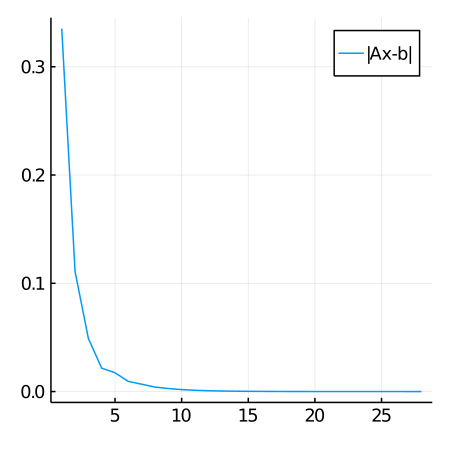

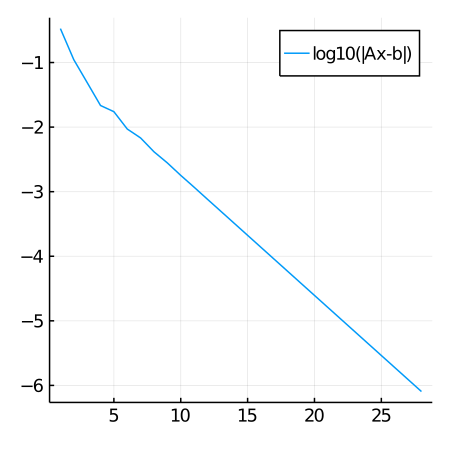

In [15]:
display(plot(R, label="|Ax-b|"))
display(plot(log10.(R), label="log10(|Ax-b|)"))

### Metoda Jakobiego w postaci algebraicznej

$$x_{i}^{(k+1)} = \frac{b_i - \sum\limits_{j=1}^{i-1} a_{ij}x_j^{(k)} - \sum\limits_{j=i+1}^n a_{ij}x_j^{(k)}}{a_{ii}}$$

In [16]:
function jacobi(A,b, x)
    n = size(A,1);
    xnew = zeros(n,1);
    R = [];
    for it=1:30
        for i = 1:n
            s = 0;
            for j = 1:n
                if j != i
                    s = s + x[j] * A[i,j];
                end
            end        
            xnew[i] = 1/A[i,i]*(b[i] - s);
        end
        x = xnew
        push!(R,  norm(A*x - b));
    end
    return x, R
end

jacobi (generic function with 1 method)

In [17]:
#@benchmark 
x, R = jacobi(A,[1,2,3], rand(3,1))

([-0.0013888888888889041; 0.19375; 0.08680555555555555], Any[8.531333633558033, 1.3589268283603817, 0.14833463415399514, 0.01420339094777368, 0.0017427084019746935, 0.000342102201214582, 6.383624308042785e-5, 1.0207004702335281e-5, 1.4154390940318518e-6, 1.7028931610497637e-7  …  1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16, 1.1102230246251565e-16])

### Metoda Gaussa-Seidela w postaci macierzowej

$${\bf x}_{i+1} = - \left( {\bf L} + {\bf D} \right)^{-1}{\bf U} {\bf x}  + \left( {\bf L} + {\bf D} \right)^{-1} {\bf b}$$

In [18]:


function gauss_seidel_mat(A, b, x, eps=1e-6)
    n = size(A,1);
    xnew = zeros(n,1);
    R = [];
    D = Diagonal(A);
    L = tril(A,-1);
    U = triu(A,1);
    invLD = inv(L+D)
    B = -invLD*(U)
    c = invLD*b
    for i=1:300
        x = B * x + c;
        e = norm(A*x - b)
        push!(R, e)
        
        if e < eps
            break
        end
    end
    return x, R
end

gauss_seidel_mat (generic function with 2 methods)

In [19]:
@benchmark x, R = gauss_seidel_mat(A,[1,2,3], rand(3,1))

BenchmarkTools.Trial: 
  memory estimate:  7.36 KiB
  allocs estimate:  89
  --------------
  minimum time:     5.620 μs (0.00% GC)
  median time:      6.571 μs (0.00% GC)
  mean time:        7.442 μs (7.17% GC)
  maximum time:     618.843 μs (98.42% GC)
  --------------
  samples:          10000
  evals/sample:     5

### Metoda Gaussa-Seidela w postaci algebraicznej

$$\begin{align*}
x_1^{(i+1)} &= \frac{1}{a_{11}} \left(b_1 - a_{12}x_2^{(i)}  -  a_{13}x_3^{(i)} \right) \\
x_2^{(i+1)} &= \frac{1}{a_{22}} \left(b_2 - a_{21}x_1^{(i+1)}  - a_{23}x_3^{(i)} \right) \\
x_3^{(i+1)} &= \frac{1}{a_{33}} \left(b_3 - a_{32}x_1^{(i+1)} - a_{32}x_2^{(i+1)} \right) \\
\end{align*}$$

$$x_{i}^{(k+1)} = \frac{b_i - \sum\limits_{j=1}^{i-1} a_{ij}x_j^{(k+1)} - \sum\limits_{j=i+1}^n a_{ij}x_j^{(k)}}{a_{ii}}; i=1,2,\ldots,n; k = 0,1,2,\ldots$$

In [20]:
function gauss_seidel(A, b, x, eps=1e-6)
    n = size(A,1);
    xnew = zeros(n,1);
    R = [];
    for it=1:30
        for i = 1:n
            s = 0;
            for j = 1:n
                if j != i
                    s = s + xnew[j] * A[i,j];
                end
            end
            xnew[i] = 1/A[i,i]*(b[i] - s);
        end
        x = xnew
        e = norm(A*x - b)
        push!(R,  e);
        if e < eps
            break
        end
    end
    
    return x, R
end

gauss_seidel (generic function with 2 methods)

In [21]:
@benchmark x, R = gauss_seidel(A,[1,2,3], rand(3,1))

BenchmarkTools.Trial: 
  memory estimate:  4.19 KiB
  allocs estimate:  63
  --------------
  minimum time:     2.137 μs (0.00% GC)
  median time:      2.269 μs (0.00% GC)
  mean time:        2.831 μs (11.23% GC)
  maximum time:     510.825 μs (98.74% GC)
  --------------
  samples:          10000
  evals/sample:     9

### Porównanie zbieżności motedo Jakobiego i Gaussa-Seidela

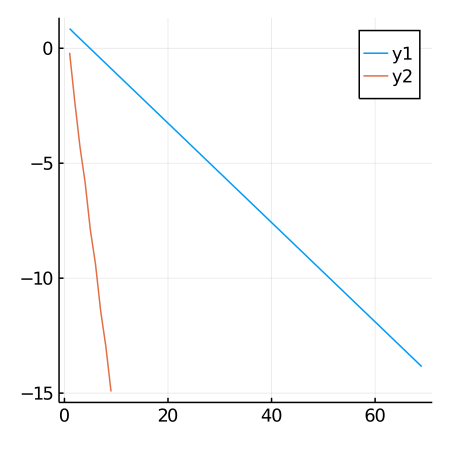

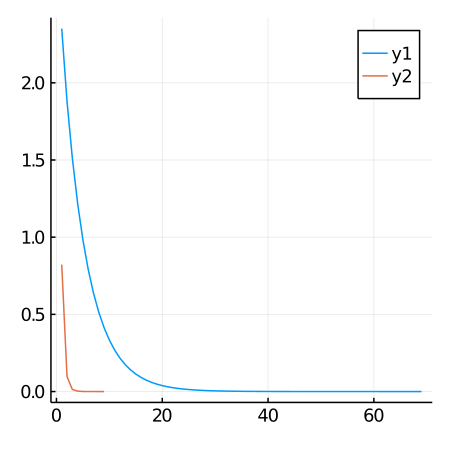

Breaking...


In [22]:
n = 30;
A = rand(n,n);
b = rand(n,1);
x = zeros(n,1);
A = A + 17*I;
xj, Rj = jacobi_mat(A,b,x)
xgs, Rgs = gauss_seidel_mat(A,b,x)
rj = norm(A*xj - b)
rgs = norm(A*xgs - b)
plot(1:length(Rj), log.(Rj))
display(plot!(1:length(Rgs), log.(Rgs)))
plot(1:length(Rj),(Rj))
display(plot!(1:length(Rgs),(Rgs)))


### Metoda relakacyjna - SOR

Implementacja macierzowa

${\bf x}^{(k+1)} = ( {\bf D} + \omega {\bf L} )^{-1} ((1-\omega) {\bf D} - \omega {\bf U} ) {\bf x}^{(k)} + \omega ({\bf D} + \omega {\bf L})^{-1} b$

[0.557736109437785; -0.11213117253852455; -0.016144923161994625; 0.1248463085481441]

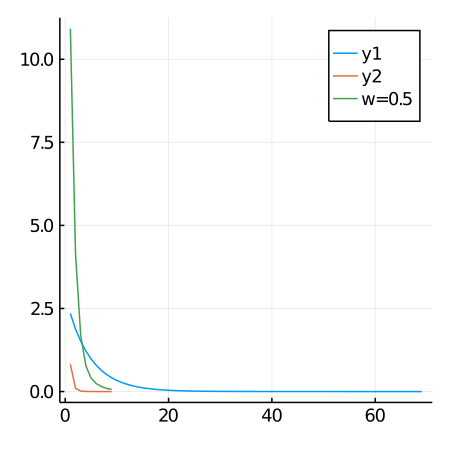

In [23]:
A = [2 1.3 0 0
    1 6 0 1
    0 1 3 1
    1 0 1 4];
b = [1; 0; 0; 1]
n = length(b);

D = Diagonal(A)
L = tril(A,-1);
U = triu(A,1);

w = 1.2;
w = 1.0;
w = 0.9;
w = 0.5;

B = inv(D+w*L) * ((1-w)*D - w*U);
c = w*inv(D+w*L)*b;
x = ones(4,1);

R = []
push!(R,norm(A*x-b))
for i=1:8
    x = B*x+c;
    e = norm(A*x - b)
    push!(R, e)
end
print(x)

plot!(R, label="w=$(w)")


### Analiza promienia spektralnego w zależności od współczynnika $\omega$

Celem jest narysowanie przebiegu za pomocą przenaalizujemy jak zmieniać się wartość promienia spektralnego, czyli warunek i szybkość zbieżności. (Im mniejsza wartość współczynnika spektralnego tym szybsza zbieżność algorytmu.)

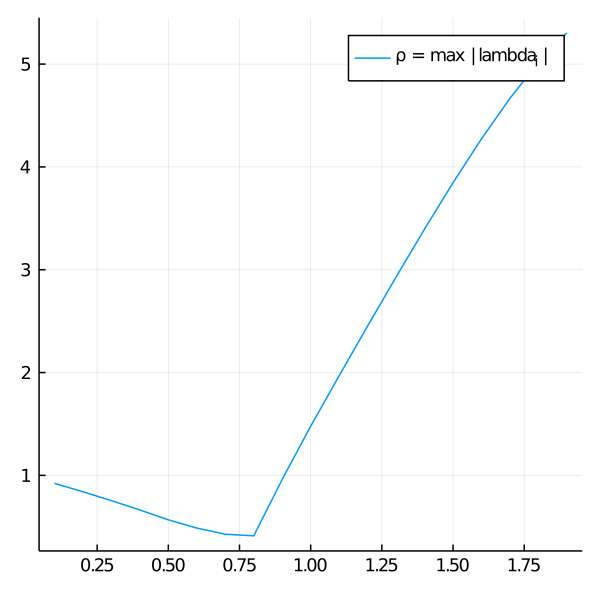

0.4117785357695135

In [24]:
A = [2 10.3 10 -11
    -1 6 0 1
    0 1 3 1
    1 0 1 4];
b = [1; 0; 0; 1]
n = length(b);

#M = inv(Diagonal(A))
#M = inv(tril(A))
#A = M*A
#b = M*b

D = Diagonal(A)
L = tril(A,-1);
U = triu(A,1);

i = 1;
conv = [];
for w=0.1:0.1:1.9
    B = inv(D+w*L) * ((1-w)*D - w*U);
    lambda_max = maximum(abs.(eigvals(B)));
    push!(conv, lambda_max);
    i = i +1;
end
display(plot(0.1:0.1:1.9, conv, 
    label="\\rho = max | \\lambda_{i} | ", 
    size=(400,400)))
minimum(conv)

## Zadanie do rozwiązania samodzielenego.

Zaimplementuj funkcję do metody SOR($\omega$) w wariancie algebraicznym. Napisz kod sprawdzający poprawność działania dla przykładowej macierzy.

Osoby, które znajdą to zadanie i prześlą do ISODa rozwiązanie w postacie kodu oraz funkcji testującej otrzymają dodatkowe punkty do zaliczenia.

In [25]:
function sor_algebraiczny(A,b,x0,eps=1e-6)
    println("...........")
    return x, R
end

sor_algebraiczny (generic function with 2 methods)